
🔹 JSON 데이터 로드 중...
✅ JSON 로드 완료! 데이터 개수: 32860, 차원: 768
✅ 번역된 영어 문장: A scene from the Western era where a man throws dynamite and the door explodes

✅ 입력된 쿼리 벡터: (1, 768)

🔍 HNSW 인덱스 생성 중...

🔍 FAISS 인덱스 생성 중...

🔍 ScaNN 인덱스 생성 중...

🔍 Annoy 인덱스 생성 중...

🔹 검색 속도 비교 결과
HNSW: 0.0001 s
FAISS: 0.0376 s
ScaNN: 0.0083 s
Annoy: 0.0001 s

🔍 가장 유사한 데이터 (FAISS 기준)
⚠️ 검색 결과가 없습니다.


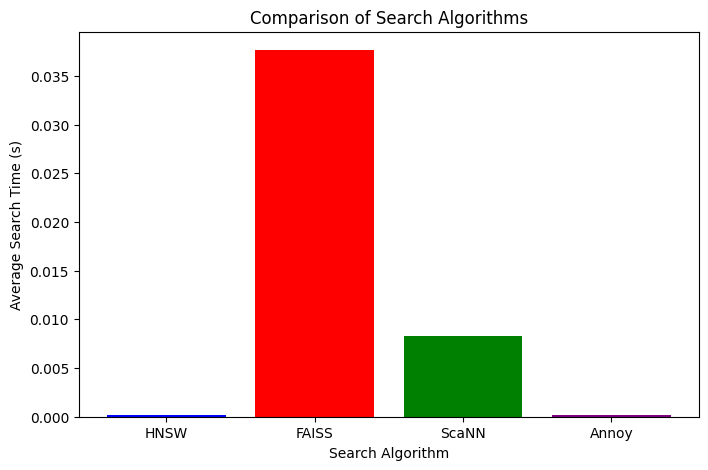

In [9]:
from deep_translator import GoogleTranslator
from sentence_transformers import SentenceTransformer
import time
import json
import numpy as np
import hnswlib
import faiss
import scann
import matplotlib.pyplot as plt
from annoy import AnnoyIndex

# ======================== JSON 데이터 로드 ========================
json_path = "/data/ephemeral/home/retrieval/json/caption_embedding_tf.json"  # JSON 파일 경로

print("\n🔹 JSON 데이터 로드 중...")
with open(json_path, "r") as f:
    json_data = json.load(f)  # json_data는 리스트(list)

# 모든 아이템에서 "embedding" 벡터만 추출하여 배열로 변환
embeddings = np.array([item["embedding"] for item in json_data], dtype=np.float32)

dim = embeddings.shape[1]  # 벡터 차원
num_elements = embeddings.shape[0]  # 데이터 개수 (33,000개)

top_k = 5  # 검색할 상위 k개
num_trials = 100  # 검색 실행 횟수

print(f"✅ JSON 로드 완료! 데이터 개수: {num_elements}, 차원: {dim}")

# ======================== 번역기 및 모델 설정 ========================
translator = GoogleTranslator(source='ko', target='en')
model = SentenceTransformer("all-mpnet-base-v2")  # SentenceTransformer 모델 설정

# ======================== 사용자 입력 받기 ========================
query_ko = input("\n🔹 검색할 쿼리를 입력하세요 (한국어 가능): ")
query_en = translator.translate(query_ko)
print(f"✅ 번역된 영어 문장: {query_en}")

# 문장을 임베딩하여 벡터로 변환
query = model.encode(query_en, convert_to_numpy=True).reshape(1, -1)

if query.shape[1] != dim:
    print(f"❌ 생성된 벡터 차원이 {query.shape[1]}인데, 데이터셋은 {dim}차원입니다!")
    exit()

print(f"\n✅ 입력된 쿼리 벡터: {query.shape}")

# ======================== 결과 저장 ========================
timing_results = {
    "HNSW": [],
    "FAISS": [],
    "ScaNN": [],
    "Annoy": []
}

# ======================== 검색 알고리즘 실행 ========================

### 1️⃣ HNSW (hnswlib)
print("\n🔍 HNSW 인덱스 생성 중...")
hnsw_index = hnswlib.Index(space='l2', dim=dim)
hnsw_index.init_index(max_elements=num_elements, ef_construction=200, M=16)
hnsw_index.add_items(embeddings, np.arange(num_elements))
hnsw_index.set_ef(50)

for _ in range(num_trials):
    start_time = time.perf_counter()
    labels, distances = hnsw_index.knn_query(query, k=top_k)
    timing_results["HNSW"].append(time.perf_counter() - start_time)

### 2️⃣ FAISS
print("\n🔍 FAISS 인덱스 생성 중...")
faiss_index = faiss.IndexFlatL2(dim)
faiss_index.add(embeddings)

for _ in range(num_trials):
    start_time = time.perf_counter()
    distances, labels = faiss_index.search(query, top_k)
    timing_results["FAISS"].append(time.perf_counter() - start_time)

### 3️⃣ ScaNN (query를 1D로 변환)
print("\n🔍 ScaNN 인덱스 생성 중...")
scann_index = scann.scann_ops_pybind.builder(embeddings, 10, "dot_product").score_brute_force().build()

for _ in range(num_trials):
    start_time = time.perf_counter()
    labels, distances = scann_index.search(query.flatten(), top_k)  # ✅ 1D 변환 필수
    timing_results["ScaNN"].append(time.perf_counter() - start_time)

### 4️⃣ Annoy
print("\n🔍 Annoy 인덱스 생성 중...")
annoy_index = AnnoyIndex(dim, 'angular')
for i in range(num_elements):
    annoy_index.add_item(i, embeddings[i])
annoy_index.build(10)

for _ in range(num_trials):
    start_time = time.perf_counter()
    labels = annoy_index.get_nns_by_vector(query.flatten().tolist(), top_k, include_distances=True)
    timing_results["Annoy"].append(time.perf_counter() - start_time)

# 평균 실행 시간 계산
avg_times = {method: np.mean(times) for method, times in timing_results.items()}

# ======================== 결과 출력 ========================
print("\n🔹 검색 속도 비교 결과")
for method, time_taken in avg_times.items():
    print(f"{method}: {time_taken:.4f} s")

# ======================== 가장 유사한 결과 출력 ========================
print("\n🔍 가장 유사한 데이터 (FAISS 기준)")
if isinstance(labels, np.ndarray) and labels.ndim > 1:
    for i, idx in enumerate(labels[0]):
        print(f"{i+1}. Index: {idx}, 거리: {distances[0][i]:.4f}")
else:
    print("⚠️ 검색 결과가 없습니다.")

# ======================== 결과 시각화 ========================
plt.figure(figsize=(8, 5))
plt.bar(avg_times.keys(), avg_times.values(), color=['blue', 'red', 'green', 'purple'])
plt.xlabel("Search Algorithm")
plt.ylabel("Average Search Time (s)")
plt.title("Comparison of Search Algorithms")
plt.show()



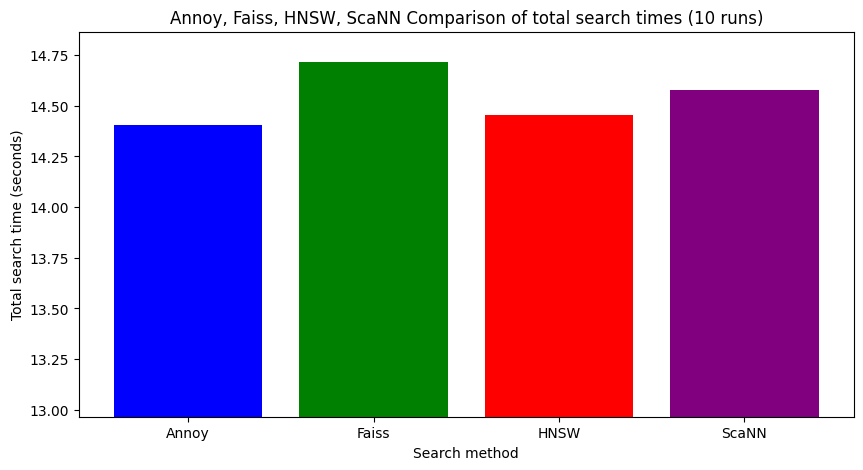

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt

# 검색 클래스 임포트 (각 검색 클래스를 정의한 모듈에서 가져오기)
from search.annoy_search import AnnoySearch
from search.faiss_search import FaissSearch
from search.hnsw_search import HNSWSearch
from search.scann_search import ScaNNSearch

# JSON 데이터 파일 경로
JSON_PATH = "json/caption_embedding_tf.json"
QUERY_TEXT = "달리던 차에서 사람이 떨어져 도로에서 구르는 장면"  # 테스트할 쿼리 텍스트
ITERATIONS = 10  # 각 검색 방법을 몇 번 반복할지 설정

def measure_time(search_class, json_path, query_text, iterations=10, **kwargs):
    searcher = search_class(json_path, **kwargs)
    total_time = 0
    
    for _ in range(iterations):
        start_time = time.perf_counter()
        searcher.find_similar_captions(query_text, top_k=3)
        end_time = time.perf_counter()
        total_time += (end_time - start_time)
    
    return total_time

# 각 검색 알고리즘의 총 실행 시간 측정
results = {}
results["Annoy"] = measure_time(AnnoySearch, JSON_PATH, QUERY_TEXT, ITERATIONS)
results["Faiss"] = measure_time(FaissSearch, JSON_PATH, QUERY_TEXT, ITERATIONS)
results["HNSW"] = measure_time(HNSWSearch, JSON_PATH, QUERY_TEXT, ITERATIONS)
results["ScaNN"] = measure_time(ScaNNSearch, JSON_PATH, QUERY_TEXT, ITERATIONS)

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Search method")
plt.ylabel("Total search time (seconds)")
plt.title("Annoy, Faiss, HNSW, ScaNN Comparison of total search times (10 runs)")
plt.ylim(min(results.values()) * 0.9, max(results.values()) * 1.01)  # y축 범위를 좀 더 구체적으로 조정
plt.show()
